# <p style='text-align: center;'>**Data preparation** </p>
<p style='text-align: center;'>prepara the data to use in the models</p>

## Outline

- [fetch the data](#0)
- [visualize & explore the data the data](#1)
- [original data](#2)
    - [1.1 original data imbalanced](#2.1)
    - [1.2 original data oversampled](#2.2)
    - [1.3 original data undersampled](#2.3)
- [the preprocessed data (based on [MortezaHeidaris paper](https://www.sciencedirect.com/science/article/pii/S138650562030959X) )](#3)
    - [2.1 Dot product attention](#2.1)
        - [Exercise 01](#ex01)
    - [2.2 Causal Attention](#2.2)
        - [Exercise 02](#ex02)
    - [2.3 Transformer decoder block](#2.3)
        - [Exercise 03](#ex03)
    - [2.4 Transformer Language model](#2.4)
        - [Exercise 04](#ex04)
- [Part 3: Training](#3)
    - [3.1 Training the model](#3.1)
        - [Exercise 05](#ex05)
- [Part 4: Evaluation](#4)
    - [4.1 Loading in a trained model](#4.1)
- [Part 5: Testing with your own input](#5) 
    - [Exercise 6](#ex06)
    - [5.1 Greedy decoding](#5.1)
        - [Exercise 07](#ex07)



In [1]:
import glob
import shutil
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd


import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imsave

from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

from skimage.feature import hog,canny
from skimage.color import rgb2gray
from skimage.filters.rank import entropy
from skimage.morphology import disk



<a name='0'></a>
### fetch the training data

In [ ]:
#fetch the data
normal_cells = glob.glob('D:/projects data/dataset/leu/C-NMC_Leukemia/training_data/normal/*.bmp')
abnormal_cells = glob.glob('D:/projects data/dataset/leu/C-NMC_Leukemia/training_data/abnormal/*.bmp')

### fetch the validation data 

In [10]:
valid_data = pd.read_csv('D:/projects data/dataset/leu/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [11]:
normal_val = valid_data.new_names[valid_data.labels ==0]
abnormal_val = valid_data.new_names[valid_data.labels ==1]
len(normal_val),len(abnormal_val)

(648, 1219)

In [15]:
normal_dest = 'D:/projects data/dataset/leu/C-NMC_Leukemia/validation_data/val_normal/'
abnormal_dest = 'D:/projects data/dataset/leu/C-NMC_Leukemia/validation_data/val_abnormal/'

src = 'D:/projects data/dataset/leu/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'

for i in normal_val:
    shutil.move(src+i, dest+i)

for i in abnormal_val:
    shutil.move(src+i, dest_abnormal+i)    

<a name='1'></a>

### visualize & explore the data

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.06it/s]


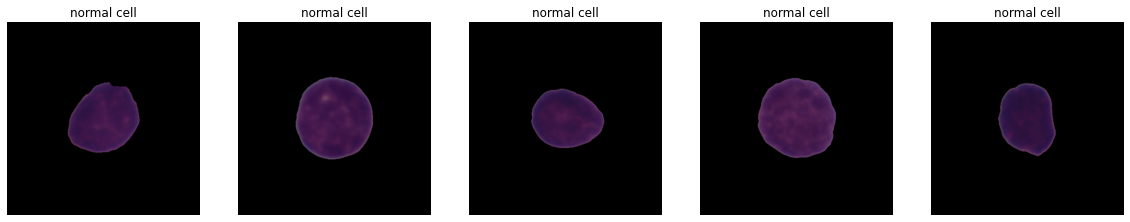

In [6]:
# Viewing some normal Images
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(normal_cells))
    img= plt.imread(normal_cells[rand])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('normal cell')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.82it/s]


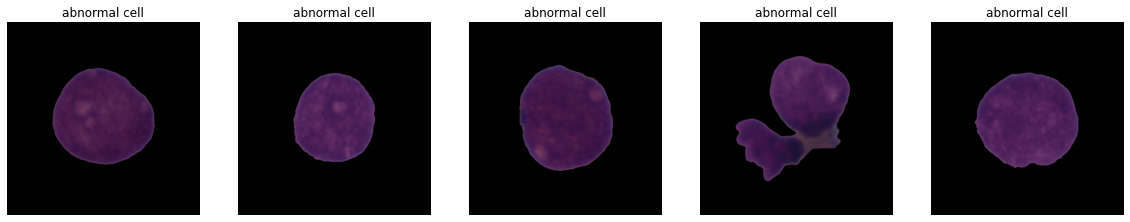

In [7]:
# Viewing some abnormal Images
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(abnormal_cells))
    img= plt.imread(abnormal_cells[rand])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('abnormal cell')

### remove useless areas form the image 

In [46]:
def crop(path):
       
    img = plt.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    cont,_=cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)#find the cell edges
    c = max(cont,key=cv2.contourArea)#find the bounds of the edges
    x,y,w,h=cv2.boundingRect(c)
    
    cr= img[(y):(y+h),(x):x+w]#slice the image using the bounds
    cropped_img = cv2.resize(cr, (224,224))
    return cropped_img 

In [47]:
abnormal_target_folder = 'D:/projects data/dataset/leu/C-NMC_Leukemia/training_data/abnormal_cropped/'
normal_target_folder = 'D:/projects data/dataset/leu/C-NMC_Leukemia/training_data/normal_cropped/'

In [48]:
normal_samples = []
abnormal_samples = []


for i in tqdm(range(0,len(abnormal_cells))):
    
    img = crop(abnormal_cells[i])
    
    imsave(abnormal_target_folder + str(i) + '.bmp',img )   
    
    if i%100 ==0:
        abnormal_samples.append(img)
        


for i in tqdm(range(0,len(normal_cells))):
    
    img = crop(normal_cells[i])

    imsave(normal_target_folder + str(i) + '.bmp', img)
    
    if i%100 ==0:
        normal_samples.append(img)
            

100%|██████████████████████████████████████████████████████████████████████████████| 4037/4037 [01:21<00:00, 49.26it/s]


In [49]:
len(normal_samples),len(abnormal_samples)

(41, 85)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 296.29it/s]


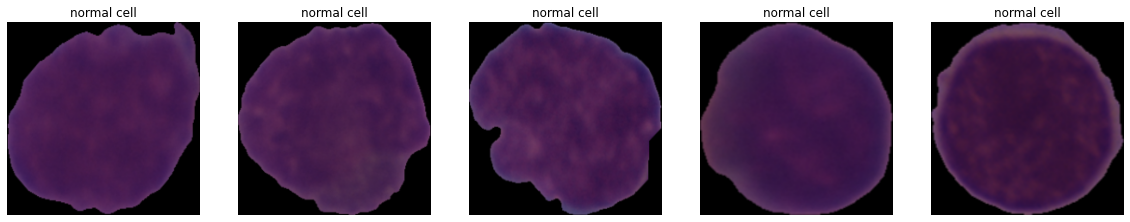

In [65]:
#show cropped images
# Viewing some abnormal Images
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(normal_samples))
    img= normal_samples[rand]
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('normal cell')

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 632.43it/s]


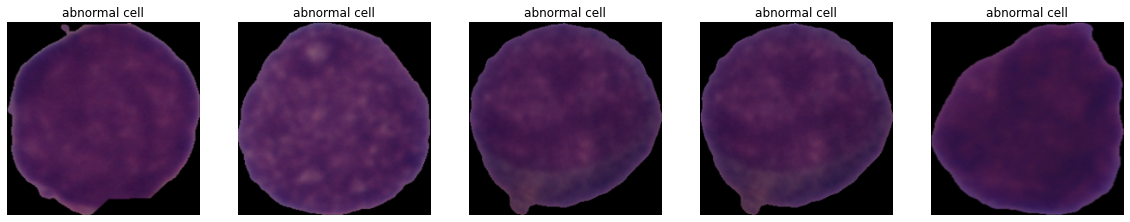

In [64]:
#show cropped images
# Viewing some abnormal Images
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(abnormal_samples))
    img= abnormal_samples[rand]
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('abnormal cell')

<a name='2'></a>

## 3-the original data

<a name='2.1'></a>

### 3.1-the original imbalanced data 

In [ ]:
# the original imbalanced data (no need to modify)

training_validation_data_path = "D:/projects data/dataset/C-NMC_Leukemia/original/imbalanced/training_data/"
testing_data_path = "D:/projects data/dataset/C-NMC_Leukemia/original/imbalanced/testing_data/"


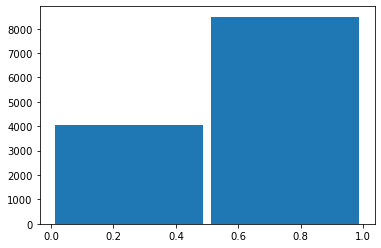

In [66]:
# visualize the data balancing
y=np.concatenate((np.zeros(len(normal_cells)),np.ones(len(abnormal_cells))))
plt.hist(y,bins=2,rwidth=0.95,)
plt.show()

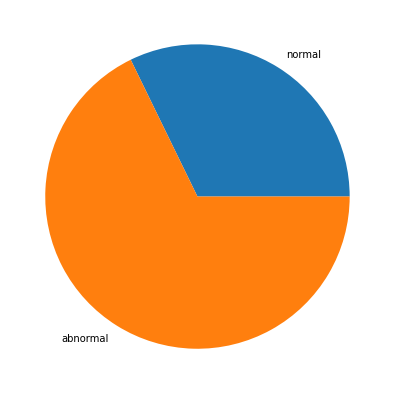

In [67]:
y_sum=[len(normal_cells), len(abnormal_cells)]
y_lab=["normal", "abnormal"]

fig = plt.figure(figsize =(10, 7))
plt.pie(y_sum,labels=y_lab)
plt.show()

In [ ]:
# the visualization shows that the data is totally imbalanced

<a name='2.2'></a>

### 3.2-the original oversampled data 

In [3]:
normal_cells = glob.glob('C:/Users/user/leukemia/imbalanced/training/normal_cropped/*.bmp')
abnormal_cells = glob.glob('C:/Users/user/leukemia/imbalanced/training/abnormal_cropped/*.bmp')
len(normal_cells),len(abnormal_cells)

(3227, 6791)

In [4]:
# original oversampled data (using SMOTE technique)synthesize new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.
x=[]
y=[]

#get the data in numpy array
for i in tqdm(range(0,len(normal_cells))):
    img = plt.imread(normal_cells[i])
    x.append(img)
    y.append(0)
    
for i in tqdm(range(0,len(abnormal_cells))):
    img = plt.imread(abnormal_cells[i])
    x.append(img)
    y.append(1)
x=np.array(x)
y=np.array(y)

x.shape,y.shape

100%|████████████████████████████████████████████████████████████████████████████| 6791/6791 [00:06<00:00, 1023.41it/s]


(10018,)

In [7]:
224*224*3

150528

In [8]:
smote= SMOTE()
#smote function only accept 1d & 2d arrays so I will convert (x,x_val) arrays from 4d -> 2d 
x= np.reshape(x,(10018,150528))
x, y = smote.fit_resample(x, y)

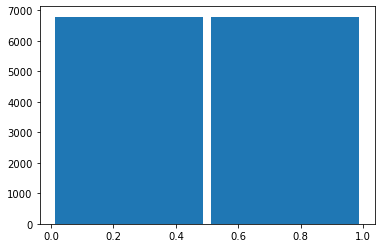

In [9]:
plt.hist(y,bins=2,rwidth=0.95,)
plt.show()

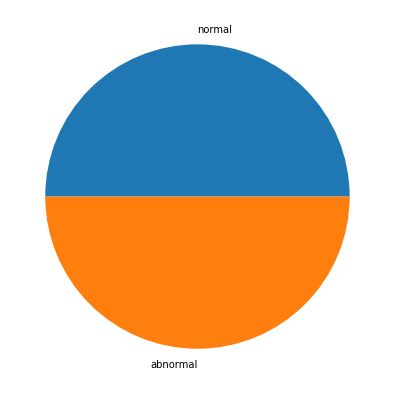

In [10]:
y_sum=[((y==0).sum()), ((y==1).sum())]
y_lab=["normal", "abnormal"]

fig = plt.figure(figsize =(10, 7))
plt.pie(y_sum,labels=y_lab)
plt.show()

In [11]:
(y==0).sum(), (y==1).sum()

(6791, 6791)

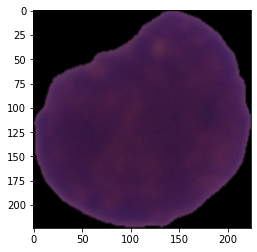

In [12]:
plt.imshow(np.reshape(x[0],(224,224,3)))

In [14]:
# save in folders
for i in tqdm(range(0,len(y))):
    img=np.reshape(x[i],(224,224,3))
    if y[i] == 0:
        path = 'C:/Users/user/leukemia/oversampled/normal/' + str(i) + '.bmp'
    else:
        path = 'C:/Users/user/leukemia/oversampled/abnormal/' + str(i) + '.bmp'

    imsave(path,img)   



100%|███████████████████████████████████████████████████████████████████████████| 13582/13582 [00:23<00:00, 572.75it/s]


<a name='2.3'></a>

### 3.3-the original undersampled data 

In [17]:
# original undersampled data
normal_cells = glob.glob('C:/Users/user/leukemia/imbalanced/training/normal_cropped/*.bmp')
abnormal_cells = glob.glob('C:/Users/user/leukemia/imbalanced/training/abnormal_cropped/*.bmp')
len(normal_cells),len(abnormal_cells)

(3227, 6791)

In [18]:
under_abnormal =pd.DataFrame(abnormal_cells)
under_abnormal.head()

,0
0,C:/Users/user/leukemia/imbalanced/training/abn...
1,C:/Users/user/leukemia/imbalanced/training/abn...
2,C:/Users/user/leukemia/imbalanced/training/abn...
3,C:/Users/user/leukemia/imbalanced/training/abn...
4,C:/Users/user/leukemia/imbalanced/training/abn...


In [19]:
under_abnormal = under_abnormal.sample(3227)
len(under_abnormal)

3227

In [20]:
under_abnormal=under_abnormal.to_numpy().flatten()
under_abnormal.shape

(3227,)

In [21]:
for i in tqdm(range(0,len(under_abnormal))):
    
    img = plt.imread(under_abnormal[i])
    imsave('C:/Users/user/leukemia/undersampled/abnormal/' + str(i) + '.bmp',img)   


100%|█████████████████████████████████████████████████████████████████████████████| 3227/3227 [00:09<00:00, 328.66it/s]


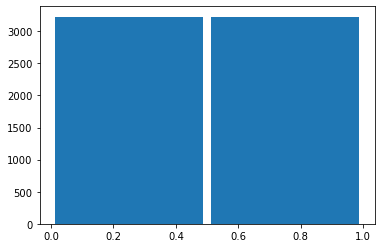

In [22]:
y=np.concatenate((np.zeros(len(normal_cells)),np.ones(len(under_abnormal))))
plt.hist(y,bins=2,rwidth=0.95,)
plt.show()

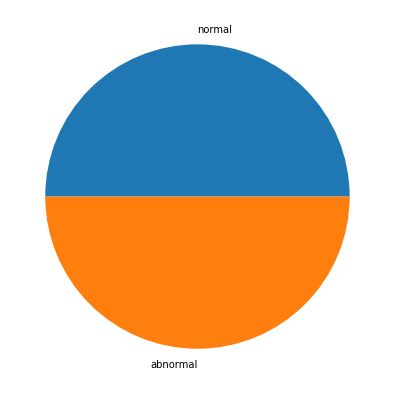

In [23]:
y_sum=[len(normal_cells), len(under_abnormal)]
y_lab=["normal", "abnormal"]

fig = plt.figure(figsize =(10, 7))
plt.pie(y_sum,labels=y_lab)
plt.show()

### prepare test data

In [112]:
test_abnormal =glob.glob('D:/projects data/dataset/leu/C-NMC_Leukemia/imbalanced/testing/abnormal/*.bmp')
test_normal =glob.glob('D:/projects data/dataset/leu/C-NMC_Leukemia/imbalanced/testing/normal/*.bmp')
len(test_abnormal),len(test_normal)

(1700, 810)

In [113]:
1700+ 810

2510

In [114]:
#get the data in numpy array
x_test= []
y_test= []
for i in tqdm(range(0,len(test_abnormal))):
    img = plt.imread(test_abnormal[i])
    x_test.append(img)
    y_test.append(0)
    
for i in tqdm(range(0,len(test_normal))):
    img = plt.imread(test_normal[i])
    x_test.append(img)
    y_test.append(1)
    
x_test=np.array(x_test)
y_test=np.array(y_test)

len(x_test),len(y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 810/810 [00:00<00:00, 2827.35it/s]


(2510, 2510)

In [115]:
x_test.shape,y_test.shape

((2510, 224, 224, 3), (2510,))

In [116]:
pickle.dump(x_test, open("D:/projects data/dataset/leu/C-NMC_Leukemia/imbalanced/testing/x_test.pkl", 'wb'))
pickle.dump(y_test, open("D:/projects data/dataset/leu/C-NMC_Leukemia/imbalanced/testing/y_test.pkl", 'wb'))

<a name='3'></a>

## the preprocessed data (based on [MortezaHeidaris paper](https://www.sciencedirect.com/science/article/pii/S138650562030959X) )

### paper summarization
 the histogram equalization algorithm and bilateral filter are applied to process the original images to generate two sets of filtered images. Then, the original image plus these two filtered images are used as inputs of three channels of the CNN deep learning model, which increase learning information of the model.

In [2]:
def preprocess(img):
    
    img = plt.imread(img)
    gray =rgb2gray(img)

    fd, hog_image = hog(gray, orientations=8,cells_per_block=(1, 1), visualize=True)

    ent = entropy(gray, disk(1)) 

    stacked = np.dstack((gray,ent,hog_image))

    return stacked

In [4]:
#fetch the data
normal_cells = glob.glob('D:/projects data/leukemia/imbalanced/training/normal_cropped/*.bmp')
abnormal_cells = glob.glob('D:/projects data/leukemia/imbalanced/training/abnormal_cropped/*.bmp')
len(normal_cells),len(abnormal_cells)

(3227, 6791)

In [25]:
img.dtype

dtype('float64')

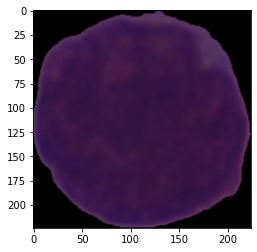

In [4]:
img=plt.imread(abnormal_cells[9])
plt.imshow(img)

D:\proooo\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


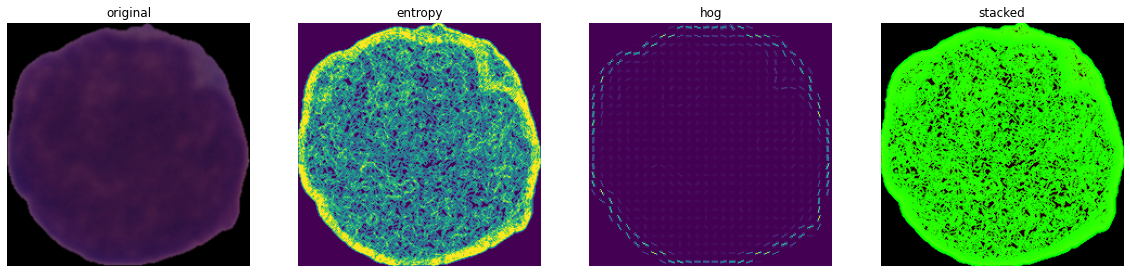

In [18]:
# show preprocessing sample
img=plt.imread(abnormal_cells[9])

gray =rgb2gray(img)

fd, hog_image = hog(gray, orientations=8,cells_per_block=(1, 1), visualize=True)

ent = entropy(gray, disk(1)) 

stacked = np.dstack((gray,ent,hog_image))

imgs=[img,ent,hog_image,stacked]
titles=['original','entropy','hog','stacked']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20,20))

for i in range(0,4):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis('off')
    imgs[i].shape

In [24]:
stacked.max()

2.3219280948873626

### for imbalanced data

In [32]:
m_save_folder='D:/projects data/leukemia/preprocessed/imbalanced/'
o_save_folder='D:/projects data/leukemia/preprocessed/oversampled/'
u_save_folder='D:/projects data/leukemia/preprocessed/undersampled/'

In [ ]:
##########################################################################################

In [6]:
img=preprocess(abnormal_cells[0])
# im = Image.fromarray(img_as_ubyte(img))
# im.save('gg.bmp')


<ipython-input-6-50ba71f3662a>:1: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  img=preprocess(abnormal_cells[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


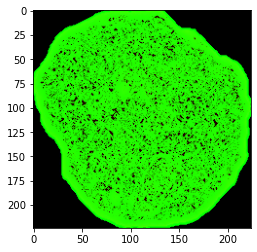

In [7]:
plt.imshow(img)

In [2]:
from skimage.exposure import rescale_intensity


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


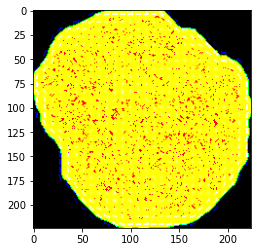

In [101]:
from skimage.exposure import rescale_intensity
img=rescale_intensity(img, out_range=(0, 255))
plt.imshow(img)

In [ ]:
##############################################################################

In [17]:
for i in tqdm(range(0,len(normal_cells))):
    
    img=preprocess(normal_cells[i])
    
#     imsave(m_save_folder+'normal/' +str(i) + '.bmp', img)
    imwrite(m_save_folder+'normal/' +str(i) + '.tif', img, photometric='rgb')

    
for i in tqdm(range(0,len(normal_cells))):
    
    img=preprocess(normal_cells[i])
    
#     imsave(m_save_folder+'normal/' +str(i) + '.bmp', img)
    imwrite(m_save_folder+'normal/' +str(i) + '.tif', img, photometric='rgb')


  0%|                                                                                         | 0/3227 [00:00<?, ?it/s]<ipython-input-17-dab701f41899>:3: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  img=preprocess(normal_cells[i])
100%|██████████████████████████████████████████████████████████████████████████████| 3227/3227 [08:01<00:00,  6.71it/s]


### for oversampled data

In [39]:
original_abnormal_o = glob.glob('D:/projects data/dataset/C-NMC_Leukemia/final/original/oversampled/abnormal/*.bmp')
original_normal_o = glob.glob('D:/projects data/dataset/C-NMC_Leukemia/final/original/oversampled/normal/*.bmp')
len(original_abnormal_o),len(original_normal_o)

(6791, 6791)

In [40]:

for i in tqdm(range(0,len(original_abnormal_o))):
    
    img=preprocess(plt.imread(original_abnormal_o[i]))
    
    imsave(o_save_folder+'abnormal/' +str(i) + '.bmp', img)
    
#     im = Image.fromarray(img)
#     im.save(m_save_folder+'abnormal/' +str(i) + '.bmp')

    
for i in tqdm(range(0,len(original_normal_o))):
    
    img=preprocess(plt.imread(original_normal_o[i]))
    
    imsave(o_save_folder+'normal/' +str(i) + '.bmp', img)

#     im = Image.fromarray(img)
#     im.save(m_save_folder+'normal/' +str(i) + '.bmp')

100%|██████████████████████████████████████████████████████████████████████████████| 6791/6791 [16:39<00:00,  6.80it/s]


### for undersampled data

In [42]:
original_abnormal_u = glob.glob('D:/projects data/dataset/C-NMC_Leukemia/final/original/undersampled/abnormal/*.bmp')
original_normal_u = glob.glob('D:/projects data/dataset/C-NMC_Leukemia/final/original/undersampled/normal/*.bmp')
len(original_abnormal_u),len(original_normal_u)

(3229, 3229)

In [43]:

for i in tqdm(range(0,len(original_abnormal_u))):
    
    img=preprocess(plt.imread(original_abnormal_u[i]))
    
    imsave(u_save_folder+'abnormal/' +str(i) + '.bmp', img)
    
#     im = Image.fromarray(img)
#     im.save(m_save_folder+'abnormal/' +str(i) + '.bmp')

    
for i in tqdm(range(0,len(original_normal_u))):
    
    img=preprocess(plt.imread(original_normal_u[i]))
    
    imsave(u_save_folder+'normal/' +str(i) + '.bmp', img)

#     im = Image.fromarray(img)
#     im.save(m_save_folder+'normal/' +str(i) + '.bmp')

100%|██████████████████████████████████████████████████████████████████████████████| 3229/3229 [09:13<00:00,  5.84it/s]


### prepare x_test

In [87]:
x_test_abnormal = glob.glob('D:/projects data/dataset/leu/C-NMC_Leukemia/imbalanced/testing/abnormal/*.bmp')
x_test_normal = glob.glob('D:/projects data/dataset/leu/C-NMC_Leukemia/imbalanced/testing/normal/*.bmp')
y_test = []
len(x_test_normal),len(x_test_abnormal)

(810, 1700)

In [3]:
x_test = pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test.pkl", 'rb'))
y_test=  pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/y_test.pkl", 'rb'))

In [4]:
x_test.max()

0.8705882352941177

In [7]:
x_test_pre=[]
for img in x_test:
    x_test_pre.append(preprocess(img))
    
x_test_pre=np.array(x_test_pre)
x_test_pre.shape

(2508, 224, 224, 3)

In [8]:
pickle.dump(x_test_pre, open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test_pre1.pkl", 'wb'))
pickle.dump(y_test, open("D:/projects data/dataset/C-NMC_Leukemia/final/y_test_pre1.pkl", 'wb'))